# Importing Libraries

In [1]:
import os
from PIL import Image
from random import shuffle
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np
import torch.nn.functional as F
import shap
from torchsummary import summary


In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

# Dataloader

In [3]:
class CancerDataset(Dataset):
    def __init__(self, root = "", shuffle_ = False, transform = None):
        self.img_paths = []
        benign_img_paths = os.listdir(root+'/' + 'Benign/')
        benign_img_paths = [root+'/Benign/' + img_path for img_path in benign_img_paths]
        malignant_img_paths = os.listdir(root+'/' + 'Malignant/')
        malignant_img_paths = [root+'/Malignant/' + img_path for img_path in malignant_img_paths]
        self.img_paths = benign_img_paths + malignant_img_paths
        self.transform = transform
        
        if shuffle_:
            shuffle(self.img_paths)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        c_type = img_path.split('/')[-1].split('.')[0]

        if 'B' in c_type:
            label = 0
        elif 'M' in c_type:
            label = 1
        
        return img, torch.tensor(label)

    def __len__(self):
        return len(self.img_paths)

In [4]:
root_train = 'Dataset/Train'
root_test = 'Dataset/Test'

In [6]:
transform = transforms.Compose(
        [
            transforms.Resize((256,256)),
            transforms.RandomCrop(224),
            transforms.ColorJitter(brightness=0.7, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [7]:
train_data = CancerDataset(root=root_train, shuffle_= True, transform= transform)
test_data = CancerDataset(root = root_test, shuffle_=False, transform=transform)

In [8]:
train_dataloader = DataLoader(dataset=train_data,  batch_size = 128, shuffle=True)
test_dataloader = DataLoader(dataset = test_data,batch_size = 128)

torch.Size([128, 3, 224, 224])
torch.Size([128])


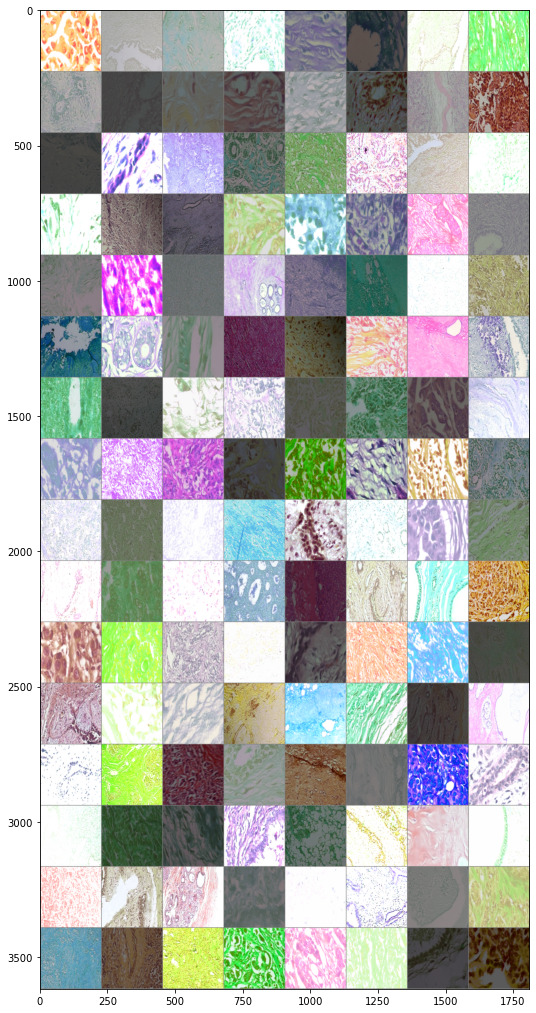

<Figure size 1080x1296 with 0 Axes>

In [9]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 
  npimg = img.numpy()
  plt.figure(figsize=(15,18))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.figure(figsize=(15,18))
  plt.show()

dataiter = iter(train_dataloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

imshow(torchvision.utils.make_grid(images))

# Backbone

In [10]:
class CanNet(nn.Module):
    
    def __init__(self):
        
        super(CanNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=3)
        self.conv3 = nn.Conv2d(12, 24, kernel_size=3)
        self.conv4 = nn.Conv2d(24, 48, kernel_size=3)
        
        self.num_flatten=48*12*12
        self.fc1 = nn.Linear(self.num_flatten, 128)
        self.fc2 = nn.Linear(128, 2)

        
    def forward(self,X):
        
    
        X = F.relu(self.conv1(X)); X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X)); X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X));X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X));X = F.max_pool2d(X, 2, 2)
        # print(X.size())

        X = X.view(-1, self.num_flatten)
        
        X = F.relu(self.fc1(X))
        X=F.dropout(X, 0.3)
        X = self.fc2(X)
        return X

net = CanNet()

In [11]:
summary(net, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 222, 222]             168
            Conv2d-2         [-1, 12, 109, 109]             660
            Conv2d-3           [-1, 24, 52, 52]           2,616
            Conv2d-4           [-1, 48, 24, 24]          10,416
            Linear-5                  [-1, 128]         884,864
            Linear-6                    [-1, 2]             258
Total params: 898,982
Trainable params: 898,982
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.05
Params size (MB): 3.43
Estimated Total Size (MB): 8.05
----------------------------------------------------------------


# Training the model

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)

In [ ]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'model_CanNet.pth')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/5], Step [0/15], Loss: 0.6926

train-loss: 1.0815, train-acc: 51.2778
validation loss: 0.7222, validation acc: 50.0000

Improvement-Detected, save-model
Epoch 2

Epoch [2/5], Step [0/15], Loss: 0.6994

train-loss: 0.8884, train-acc: 47.0556
validation loss: 0.7071, validation acc: 47.5000

Improvement-Detected, save-model
Epoch 3

Epoch [3/5], Step [0/15], Loss: 0.6932

train-loss: 0.8234, train-acc: 49.7222
validation loss: 0.7015, validation acc: 50.0000

Improvement-Detected, save-model
Epoch 4

Epoch [4/5], Step [0/15], Loss: 0.6908

train-loss: 0.7910, train-acc: 50.3333
validation loss: 0.7000, validation acc: 50.5000

Epoch 5

Epoch [5/5], Step [0/15], Loss: 0.6934


In [ ]:

transform = transforms.Compose(
        [
            transforms.Resize((224,224)),
#             transforms.CenterCrop(224)
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
test_data = CancerDataset(root = root_test, shuffle_=False, transform=transform)
test_dataloader = DataLoader(dataset = test_data,batch_size = 128, shuffle = True)


In [ ]:
batch = next(iter(test_dataloader ))
images, _ = batch

In [ ]:
plt.imshow(np.transpose(images[100], (1, 2, 0)))
label_1 = 'Bengin' if _[100].item()==0 else 'Malignant' 
print(label_1)

In [ ]:
plt.imshow(np.transpose(images[101], (1, 2, 0)))
label_2 = 'Bengin' if _[101].item()==0 else 'Malignant' 
print(label_2)

In [ ]:
images.shape

# Using Explainable AI (XAI)

In [ ]:
batch = next(iter(test_dataloader ))
images, _ = batch

background = images[:100]
test_images = images[100:102]

e = shap.DeepExplainer(net, background)
shap_values = e.shap_values(test_images)

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

In [ ]:
shap.image_plot(shap_numpy, test_numpy)
print('Img one is {}'.format(label_1))
print('Img two is {}'.format(label_2))